In [1]:
%cd ..

/Users/pedrobedmar/GoogleDrive/MASTER_BIG_DATA/tfm/code


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from etl.esios.provider import ESIOSDataProvider
from etl.generic_provider import GenericDataProvider
import lab.functions as func

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from skforecast.ForecasterAutoreg import ForecasterAutoreg

SEED=0
np.random.seed(SEED)

In [3]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [4]:
esios_provider = ESIOSDataProvider()
esios_tickers = esios_provider.get_tickers()
print(esios_tickers)

investingdotcom_tickers = ["DAILY_TTF_PRICE", "MONTHLY_TTF_PRICE"]
investingdotcom_provider = GenericDataProvider("datalake/clean/investingdotcom/", want_metadata=False, tickers=investingdotcom_tickers)
print(investingdotcom_tickers)

marketwatch_tickers = ["DAILY_COAL_PRICE"]
marketwatch_provider = GenericDataProvider("datalake/clean/marketwatch/", want_metadata=False, tickers=marketwatch_tickers)
print(marketwatch_tickers)

icap_tickers = ["CO2_EUA_PRICE"]
icap_provider = GenericDataProvider("datalake/clean/ICAP/", want_metadata=False, tickers=icap_tickers)
print(icap_tickers)

['DEMANDA_REAL', 'GENERACIÓN_MEDIDA_TOTAL', 'GENERACIÓN_MEDIDA_EÓLICA', 'GENERACIÓN_MEDIDA_HIDRÁULICA', 'GENERACIÓN_MEDIDA_NUCLEAR', 'GENERACIÓN_MEDIDA_SOLAR', 'GENERACIÓN_MEDIDA_CICLO_COMBINADO', 'GENERACIÓN_MEDIDA_CARBÓN', 'PRECIO_MERCADO_SPOT_DIARIO']
['DAILY_TTF_PRICE', 'MONTHLY_TTF_PRICE']
['DAILY_COAL_PRICE']
['CO2_EUA_PRICE']


In [58]:
forecasting_horizon = 30

nb_windows = 15
step_size = 13

lags = [1, 2, 6, 7, 13, 14, 28, 30, 31]
date_features = ["day", "day_of_week", "week_of_year", "month"]

regressor_list = [DummyRegressor(), KNeighborsRegressor(), RandomForestRegressor(random_state=SEED, n_jobs=-1),
                      GradientBoostingRegressor(random_state=SEED), SVR()]
regressor_str_list = ["DummyRegressor", "KNeighborsRegressor", "RandomForestRegressor", "GradientBoostingRegressor", "SVR"]

In [57]:
def load_and_preprocess_daily_data(start_index, end_index, date_features):
    index_type = "DatetimeIndex"
    esios_spot = esios_provider.get_series("PRECIO_MERCADO_SPOT_DIARIO", freq="H", index_type=index_type, start_index=start_index, end_index=end_index, resample_by="D", group_mode="mean")
    esios_df = esios_provider.get_all_series(freq="H", index_type=index_type, start_index=start_index, end_index=end_index, resample_by="D", group_mode="sum")
    ttf_df = investingdotcom_provider.get_series(investingdotcom_tickers[0], freq="D", index_type=index_type, start_index=start_index, end_index=end_index)
    coal_df = marketwatch_provider.get_series(marketwatch_tickers[0], freq="D", index_type=index_type, start_index=start_index, end_index=end_index)
    co2_df = icap_provider.get_series(icap_tickers[0], index_type=index_type, freq="D", start_index=start_index, end_index=end_index)

    X = esios_df.drop(['PRECIO_MERCADO_SPOT_DIARIO', 'GENERACIÓN_MEDIDA_TOTAL'], axis=1)
    X = pd.concat([X, ttf_df, coal_df, co2_df], axis=1)
    lags = []

    df_date_features = func.add_date_features(esios_spot, X, lags, 1, date_features)

    data_train = df_date_features.iloc[:-forecasting_horizon, :]
    data_test = df_date_features.iloc[-forecasting_horizon:, :]

    initial_window_length = len(data_train) - step_size*(nb_windows-1)

    return data_train.copy(), data_test.copy(), initial_window_length

In [60]:
from sklearn.ensemble import IsolationForest


def remove_outliers_isolation_forests_train_test(data_train, data_test, columns):
    outlier_detector = IsolationForest()
    for column in columns:
        outlier_detector.fit(data_train[[column]])

        outlier_prediction_train = outlier_detector.predict(data_train[[column]])
        data_train.loc[outlier_prediction_train == -1, column] = np.nan
        data_train.loc[:, column] = data_train.loc[:, column].interpolate().fillna(method='ffill').fillna(method='bfill')

        outlier_prediction_test = outlier_detector.predict(data_test[[column]])
        data_test.loc[outlier_prediction_test == -1, column] = np.nan
        data_test.loc[:, column] = data_test.loc[:, column].interpolate().fillna(method='ffill').fillna(method='bfill')

    return data_train, data_test


In [61]:
from sktime.utils.plotting import plot_series
from statistics import mean
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error, mean_absolute_error
from time import time


def crossval_model_skforecast(data, regressor_list, regressor_str_list, initial_window_length, nb_windows, step_size, lags, date_features, forecasting_horizon):
    cv_results_df_summary = pd.DataFrame(0, index=np.arange(len(regressor_str_list)),
                                         columns=["model", "mean_mase", "mean_mae", "fit_time"])
    i = 0

    for regressor_str, regressor in zip(regressor_str_list, regressor_list):
        y_pred_list = []
        y_test_list = []
        mase_list = []
        mae_list = []

        start = time()
        for w in range(nb_windows):
            data_window = data[:initial_window_length + w * step_size]

            data_window_train = data_window.iloc[:-forecasting_horizon, :].copy()
            data_window_test = data_window.iloc[-forecasting_horizon:, :].copy()

            data_window_train_iso, data_window_test_iso = remove_outliers_isolation_forests_train_test(data_window_train, data_window_test, columns=[column for column in data_window.columns if column not in date_features])

            y_window_train_iso = data_window_train_iso.iloc[:, 0]
            X_window_train_iso = data_window_train_iso.iloc[:, 1:]
            y_window_test_iso = data_window_test_iso.iloc[:, 0]
            X_window_test_iso = data_window_test_iso.iloc[:, 1:]

            forecaster = ForecasterAutoreg(
                regressor=regressor,
                lags=lags
            )

            forecaster.fit(
                y=y_window_train_iso,
                exog=X_window_train_iso
            )

            y_pred = forecaster.predict(
                steps=30,
                exog=X_window_test_iso
            )

            y_pred = pd.Series(data=y_pred, index=y_window_test_iso.index)

            mase = mean_absolute_scaled_error(y_window_test_iso, y_pred, y_train=y_window_train_iso)
            mae = mean_absolute_error(y_window_test_iso, y_pred)

            y_test_list.append(y_window_test_iso)
            y_pred_list.append(y_pred)
            mase_list.append(mase)
            mae_list.append(mae)

        end = time()

        print("Model:", regressor_str)
        print("MASEs:", mase_list)
        print("MAEs:", mae_list)
        print("Fit time:", end - start)
        print()

        cv_results_df_summary.iloc[i, 0] = regressor_str
        cv_results_df_summary.iloc[i, 1] = mean(mase_list)
        cv_results_df_summary.iloc[i, 2] = mean(mae_list)
        cv_results_df_summary.iloc[i, 3] = end - start
        i += 1

        fig, ax = plot_series(
            y_window_train_iso,
            *y_pred_list,
            markers=["o"] + ["" for x in range(nb_windows)]
        )
        plt.title("Cross-validation of " + regressor_str)
        ax.plot

    return cv_results_df_summary

## Prepandemic

In [62]:
data_train, data_test, initial_window_length = load_and_preprocess_daily_data(start_index="2018-04-01", end_index="2020-03-31", date_features=["day", "day_of_week", "week_of_year", "month"])
print(initial_window_length)

519


weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


`exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesExogWarning)
`exog` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesExogWarning)
`exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesExogWarning)
`exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesExogWarning)
`exog` has missing values. Most of machine learning models do not allow missing values. `predict` method ma

Model: DummyRegressor
MASEs: [4.437890772776405, 3.6808431426800325, 3.954303919965521, 3.749990475154949, 4.201199131875585, 3.703151844200497, 3.346631702758991, 3.8524100184633556, 3.766844150734639, 4.625720595216573, 5.015556949210086, 5.220793728904458, 4.249217267408844, 4.482049678547669, 4.701826486090757]
MAEs: [9.499166515041246, 7.232299628450124, 7.9810457128099195, 8.194310306282137, 7.799179330065366, 7.792489523581904, 7.625538324004976, 8.787595097146328, 8.477074906089358, 9.992254166666664, 11.55609750566894, 13.077650466814564, 11.247465865906623, 11.891433789650895, 12.502182942708343]
Fit time: 56.54776692390442



`exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesExogWarning)


ValueError: Input X contains NaN.
KNeighborsRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

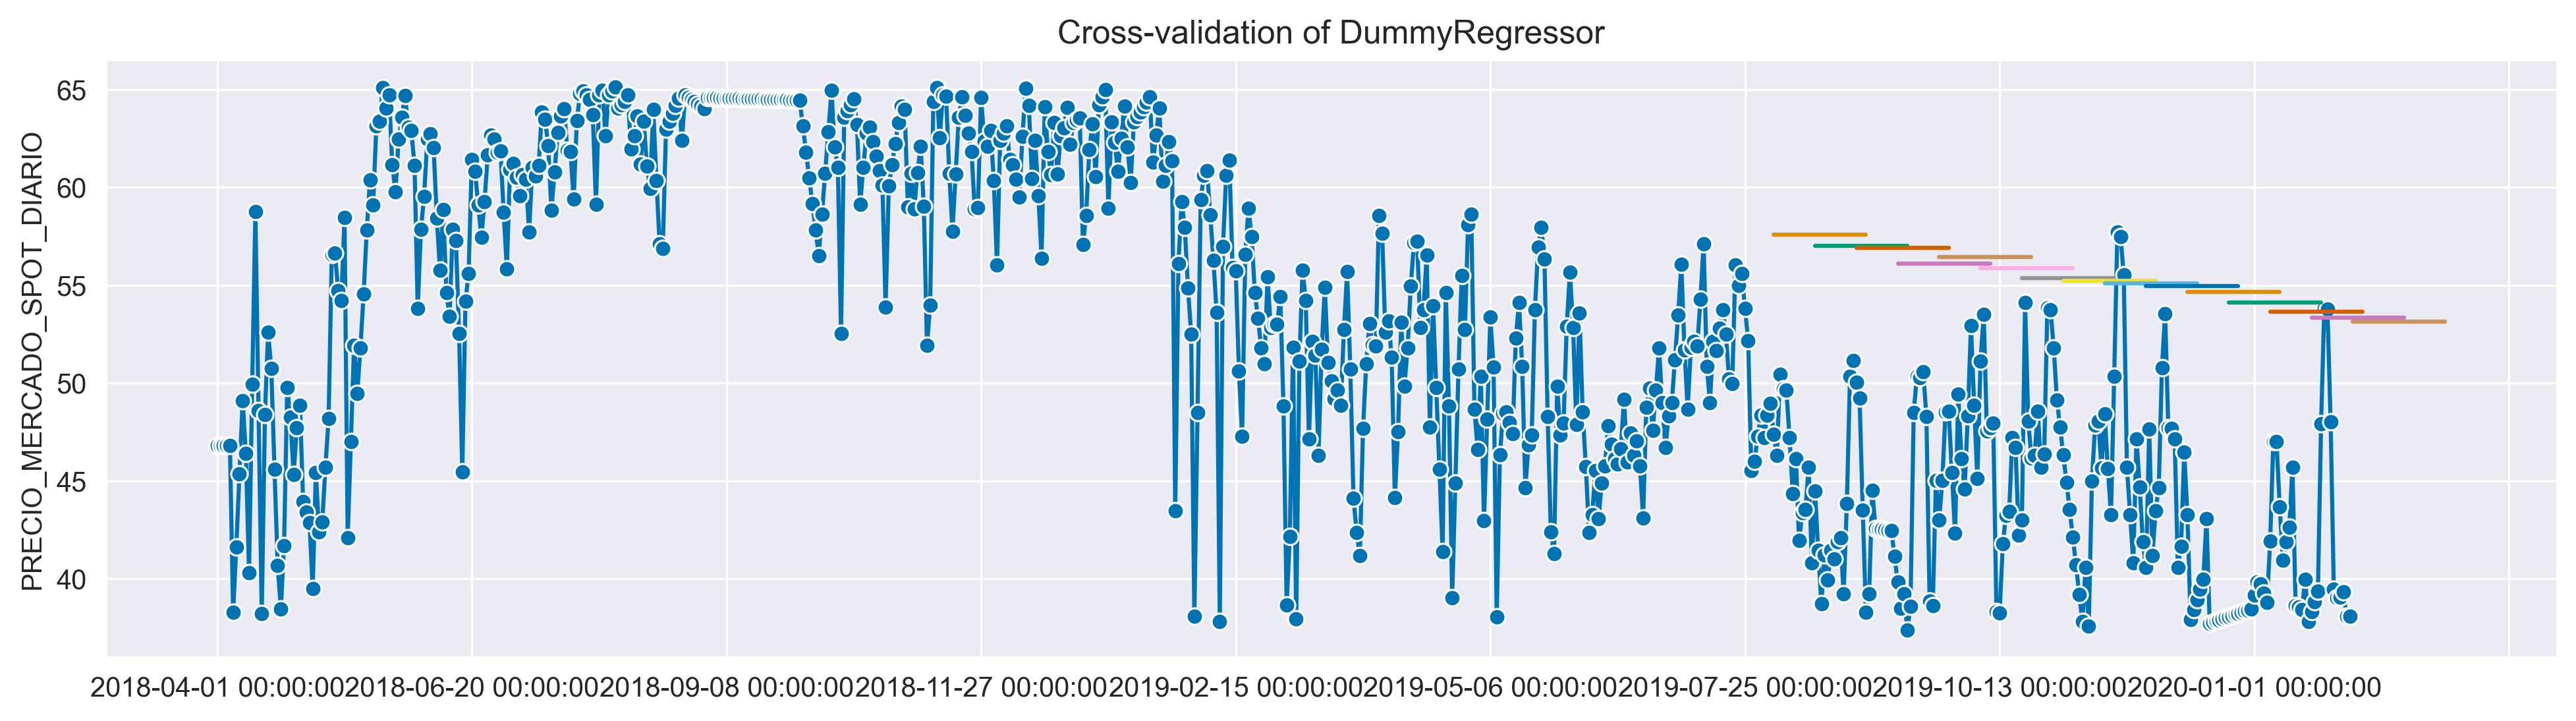

In [63]:
cv_results_df_summary = crossval_model_skforecast(data_train, regressor_list, regressor_str_list, initial_window_length, nb_windows, step_size, lags, date_features, forecasting_horizon)

In [28]:
cv_results_df_summary = cv_results_df_summary.sort_values("mean_mase")
cv_results_df_summary

,model,mean_mase,mean_mae,fit_time
3,GradientBoostingRegressor,1.615006,5.744892,4.116914
2,RandomForestRegressor,1.770184,6.297825,10.506730
1,KNeighborsRegressor,2.305199,8.213743,5.186883
4,SVR,3.201119,11.392408,1.058266
0,DummyRegressor,4.077478,14.482485,0.152956


### Final model

In [29]:
best_model_string = cv_results_df_summary.iloc[0, 0]
best_model = regressor_list[regressor_str_list.index(best_model_string)]

forecaster = ForecasterAutoreg(
                 regressor     = best_model,
                 lags          = lags
             )

forecaster.fit(
    y       = y_date_features_train,
    exog    = X_date_features_train
)

NameError: name 'y_date_features_train' is not defined

In [42]:
y_pred = forecaster.predict(
    steps   = 30,
    exog    = X_date_features_test
)

y_pred = pd.Series(data=y_pred, index=y_date_features_test.index)

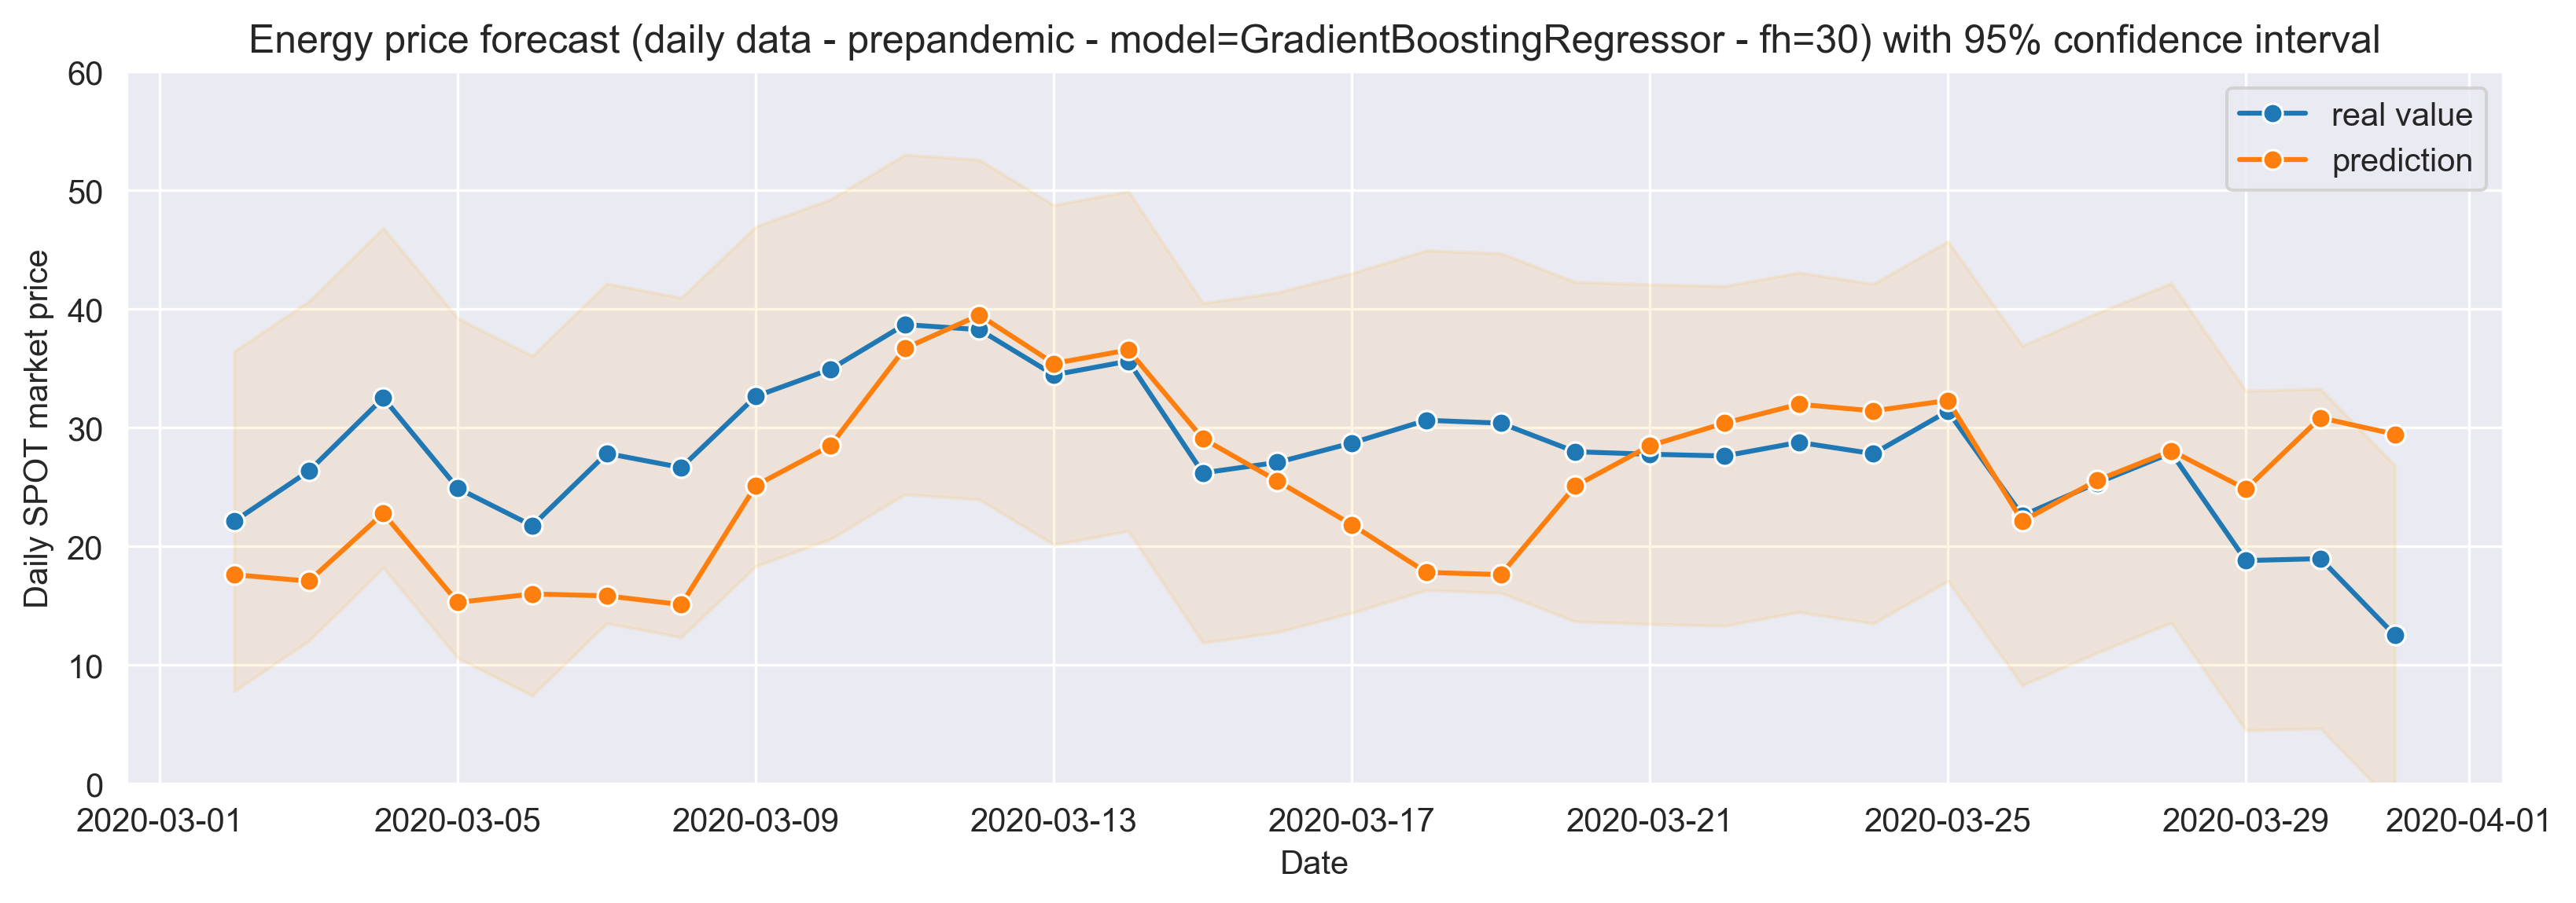

In [50]:
residuals = abs(y_pred-y_date_features_test)
RMSFE = np.sqrt(sum([x**2 for x in residuals]) / len(residuals))
band_size = 1.96*RMSFE

if type(y_date_features_test.index) is pd.core.indexes.period.PeriodIndex:
    y_date_features_test.index = y_date_features_test.index.to_timestamp()
if type(y_pred.index) is pd.core.indexes.period.PeriodIndex:
    y_pred.index = y_pred.index.to_timestamp()

fig, ax = plt.subplots(figsize=(13,4))
sns.lineplot(data=y_date_features_test, palette="deepskyblue", marker="o", ax=ax)
sns.lineplot(data=y_pred, palette="orange", marker="o", ax=ax)
ax.fill_between(y_date_features_test.index, (y_date_features_test-band_size), (y_date_features_test+band_size), color='orange', alpha=.1)
ax.set_title(f"Energy price forecast (daily data - prepandemic - model={best_model_string} - fh={forecasting_horizon}) with 95% confidence interval")
ax.set_xlabel('Date')
ax.set_ylabel('Daily SPOT market price')
ax.set_ylim([0,60])
ax.legend(loc="upper right", labels=["real value", "prediction"])
plt.show()

## Postpandemic

In [51]:
y_date_features_train, y_date_features_test, X_date_features_train, X_date_features_test, initial_window_length = load_and_preprocess_daily_data(start_index="2021-04-01", end_index="2023-03-31")
print(initial_window_length)

518


weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


Model: DummyRegressor
MASEs: [1.2729303087416246, 1.211605832660299, 1.7693774934169828, 2.198200655178813, 2.655369546257437, 2.6298599344326234, 2.880716834137795, 2.7646828986013534, 2.5529961000072245, 3.200286632449655, 4.8891219071335215, 5.874981459602429, 4.7459686002766945, 2.817884931073026, 1.0880713549966057]
MAEs: [20.834907913931445, 19.52945035460993, 28.410961381412474, 35.93920161290323, 44.612406816197336, 44.72751553852702, 49.66290602284527, 47.65772617599352, 44.008918993860156, 55.39934151180796, 85.19555425421161, 102.36601111111108, 84.05159597607395, 50.27191196308127, 19.58504042775169]
Fit time: 0.13752293586730957

Model: KNeighborsRegressor
MASEs: [0.908942546672893, 1.488076096805736, 1.9078854503861393, 2.0381555094561317, 2.1244938476306365, 2.5536254640866307, 2.9604729459339594, 3.657961369762361, 4.272807288136162, 5.143504076900611, 5.412334422413649, 4.751450060644883, 3.101421707653268, 2.4217531807202803, 2.356884605217082]
MAEs: [14.8772750000000

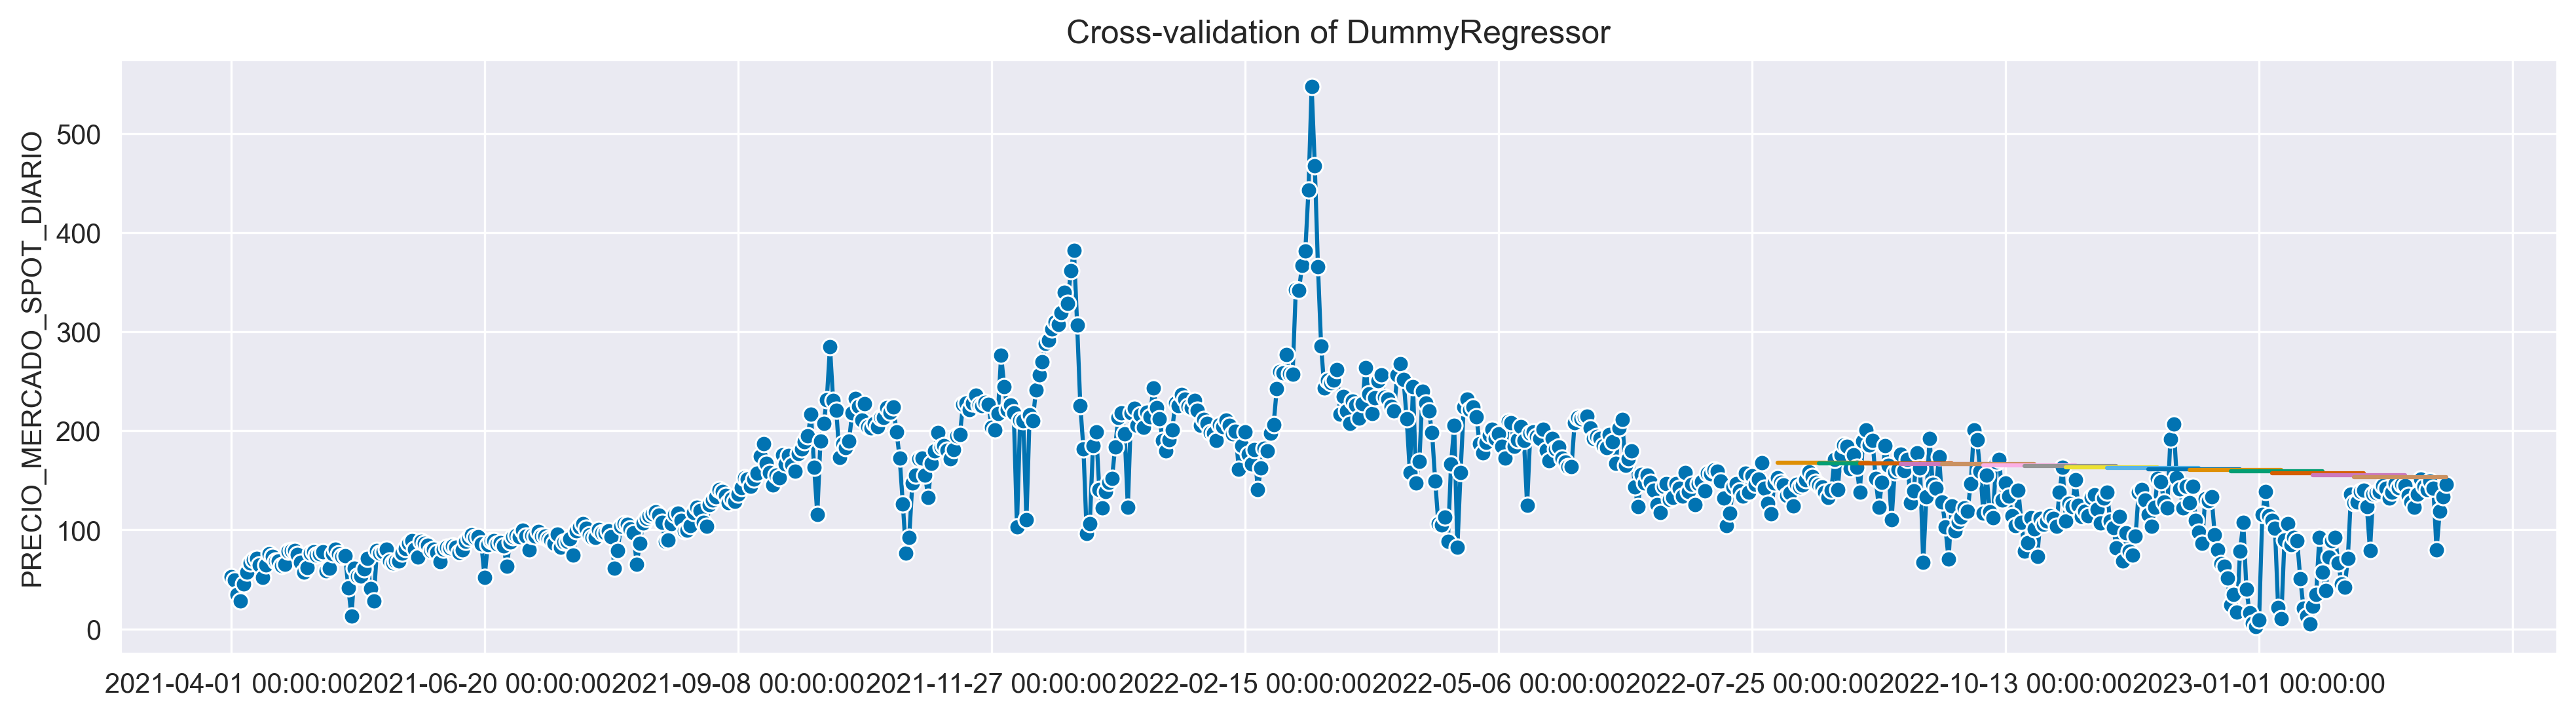

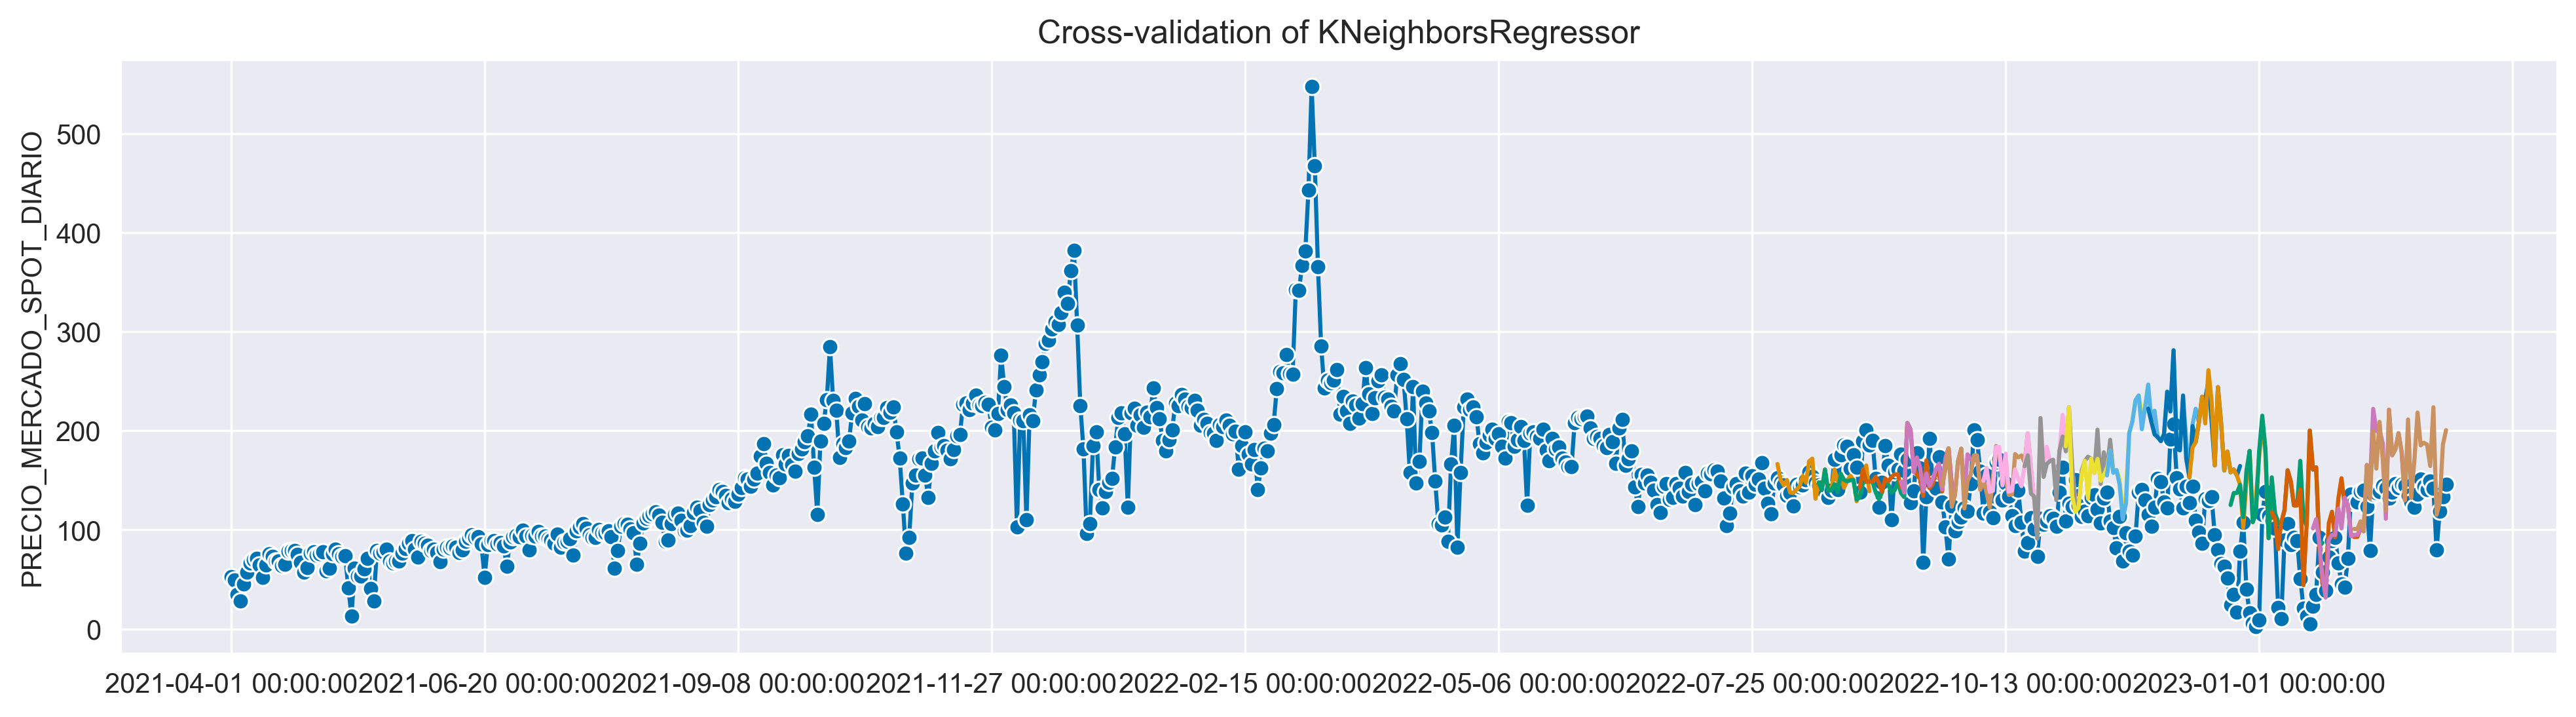

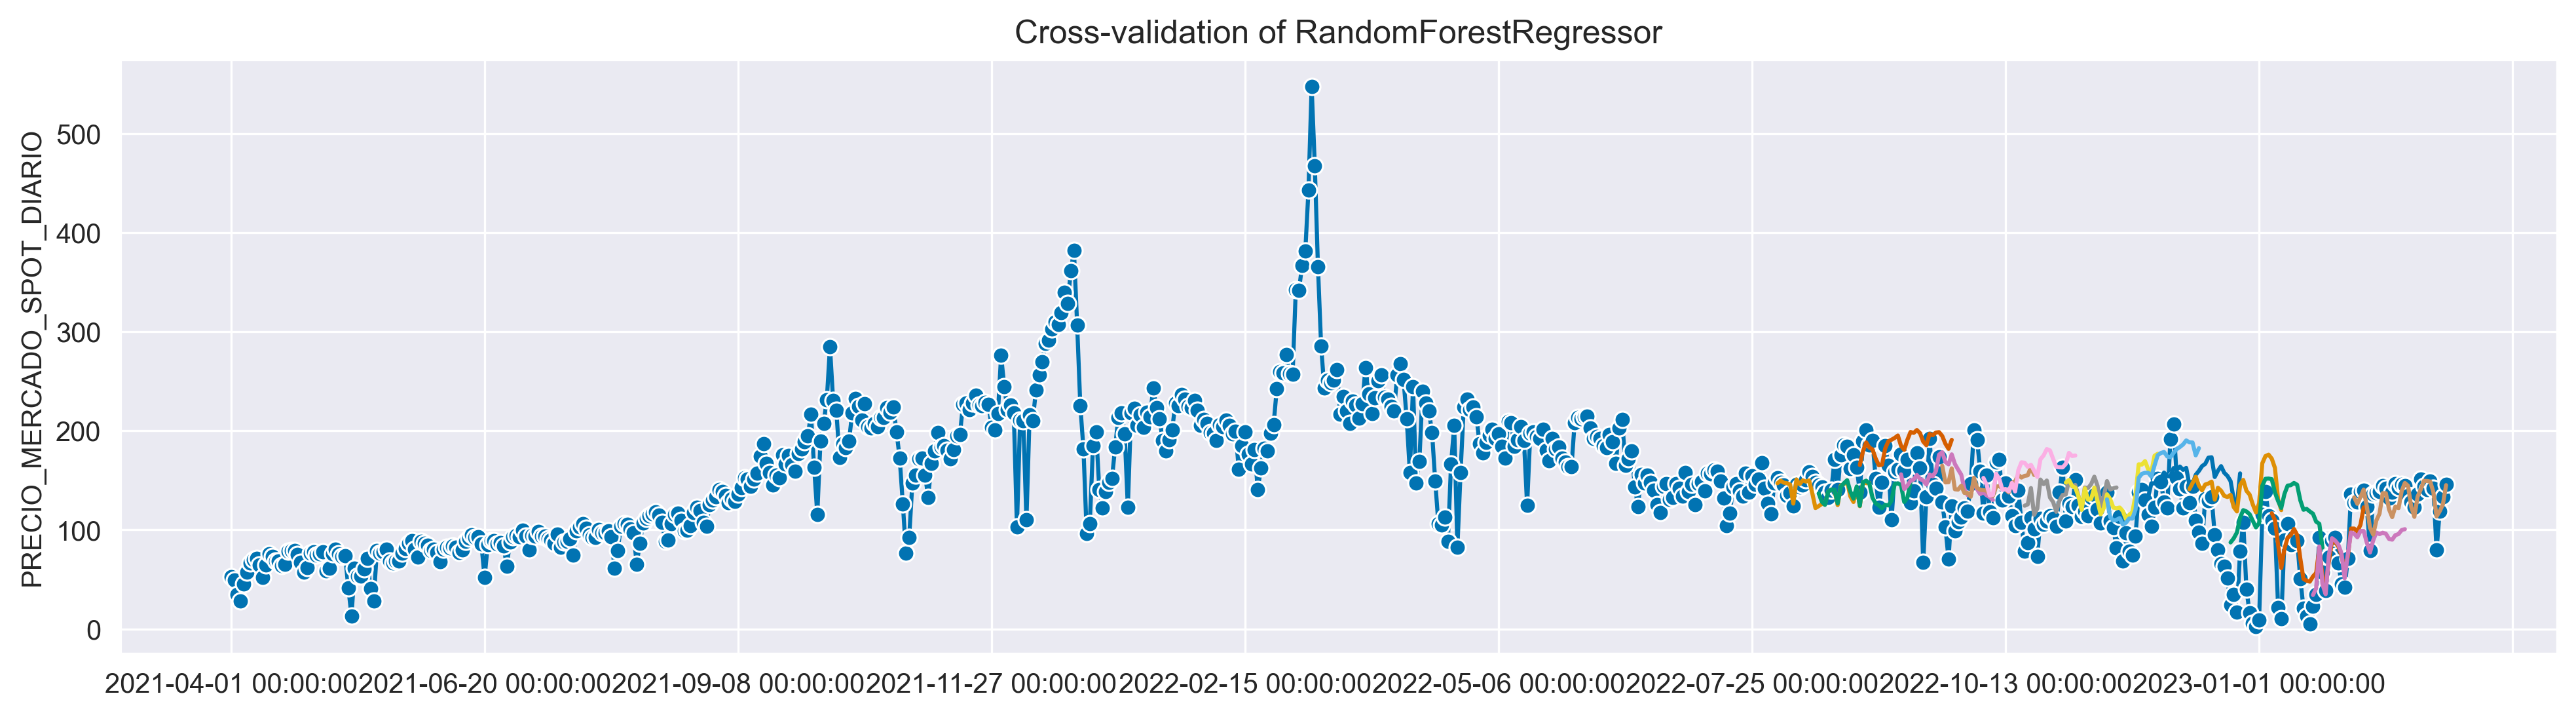

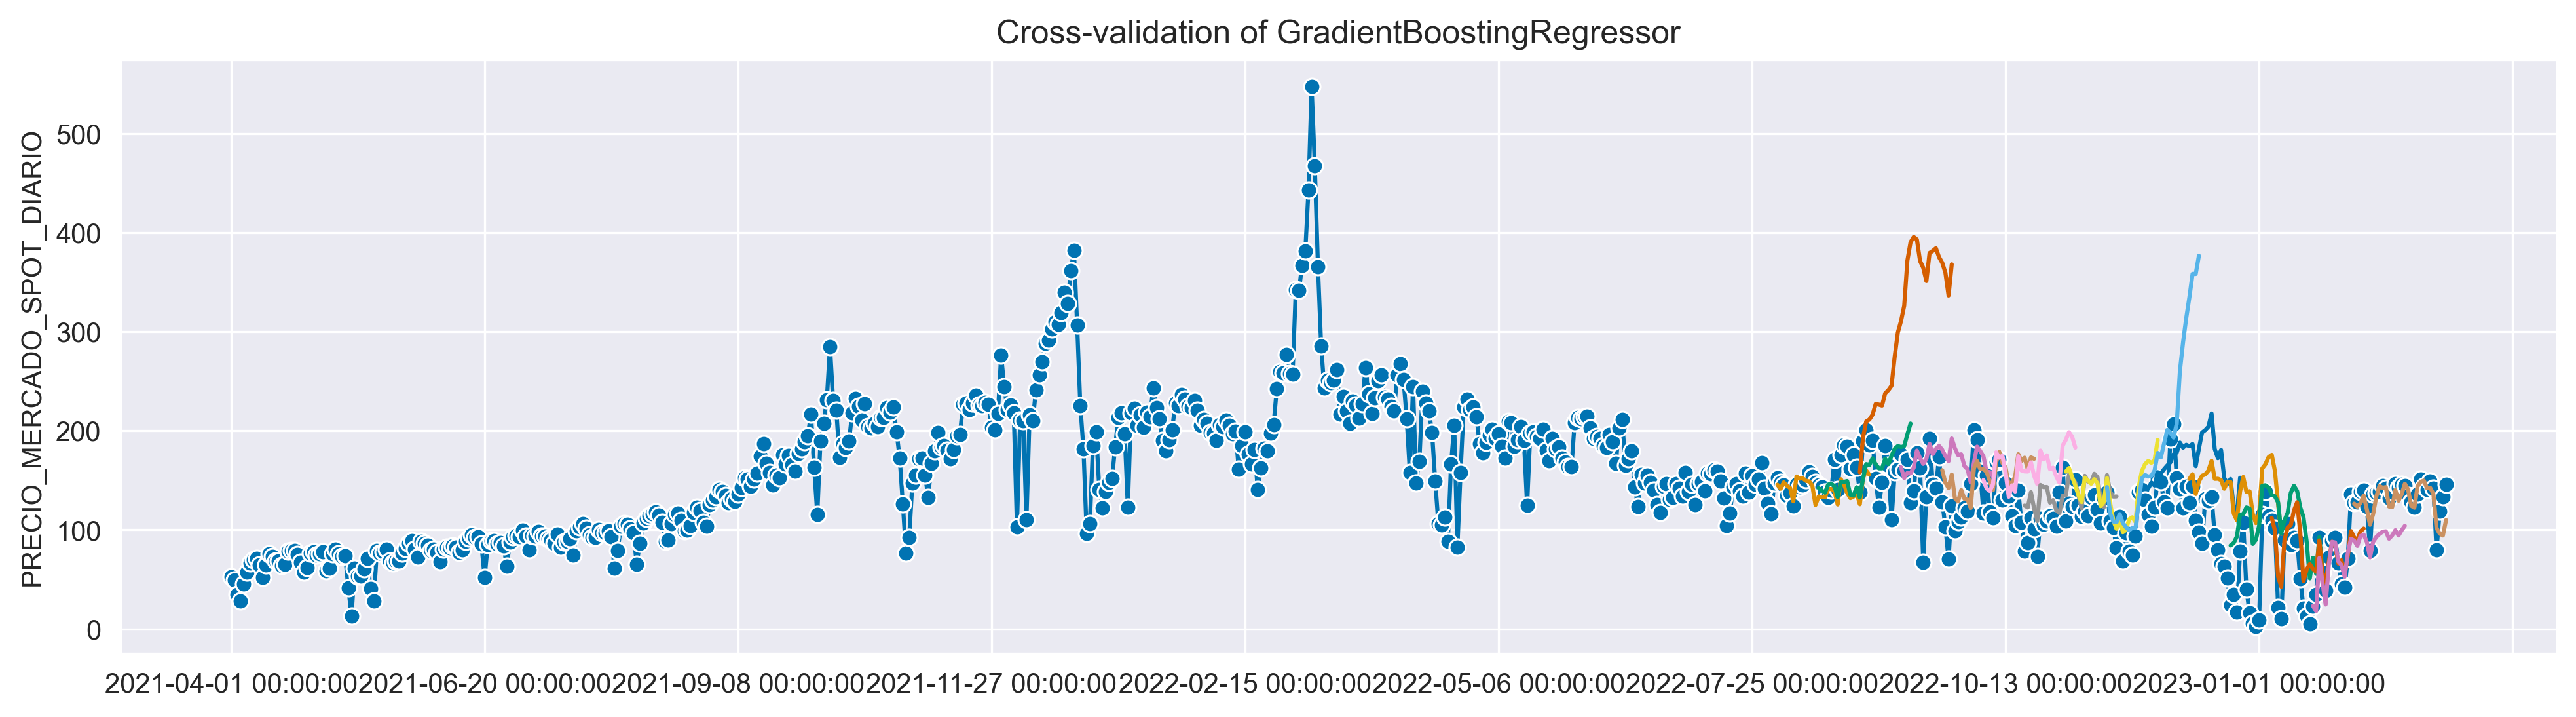

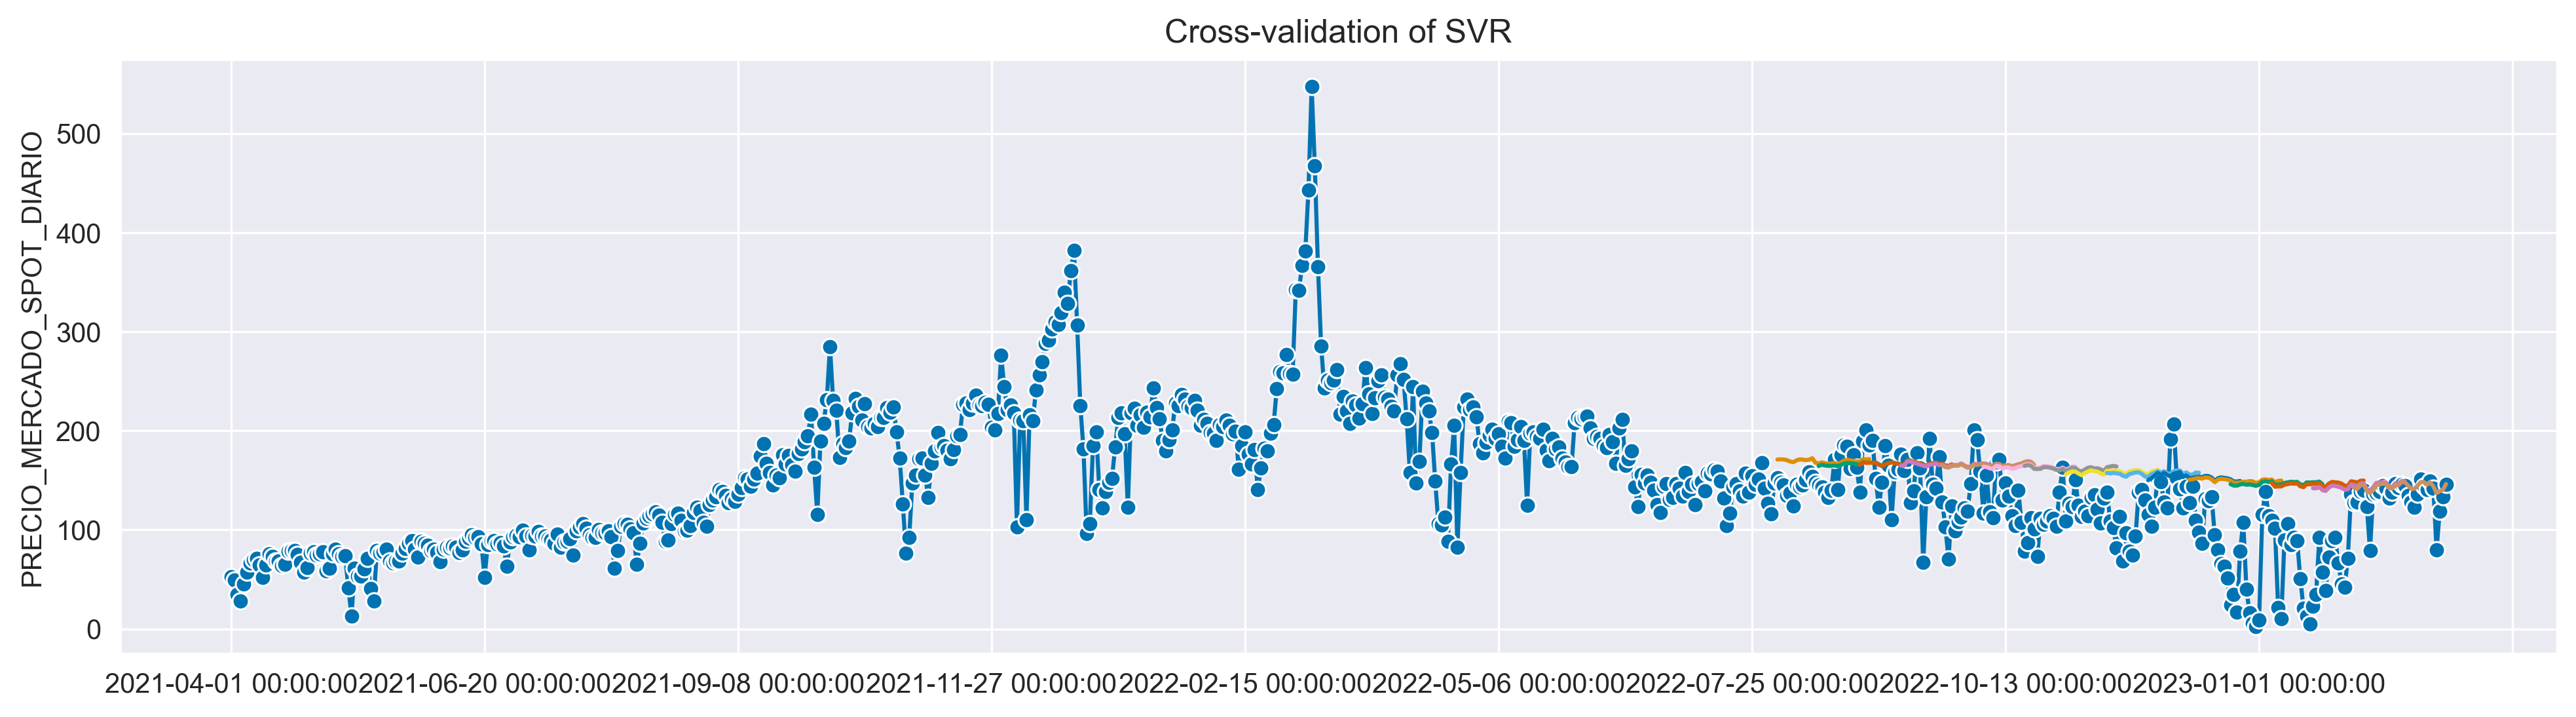

In [52]:
cv_results_df_summary = func.crossval_model_skforecast(y_date_features_train, X_date_features_train, regressor_list, regressor_str_list, initial_window_length, nb_windows, step_size, lags, forecasting_horizon)

In [53]:
cv_results_df_summary = cv_results_df_summary.sort_values("mean_mase")
cv_results_df_summary

,model,mean_mase,mean_mae,fit_time
2,RandomForestRegressor,2.014519,34.367901,7.965530
4,SVR,2.545438,43.714397,1.098447
3,GradientBoostingRegressor,2.645631,44.671871,4.489789
0,DummyRegressor,2.836804,48.816897,0.137523
1,KNeighborsRegressor,3.006651,51.759266,4.946978


### Final model

In [54]:
best_model_string = cv_results_df_summary.iloc[0, 0]
best_model = regressor_list[regressor_str_list.index(best_model_string)]

forecaster = ForecasterAutoreg(
                 regressor     = best_model,
                 lags          = lags
             )

forecaster.fit(
    y       = y_date_features_train,
    exog    = X_date_features_train
)

In [55]:
y_pred = forecaster.predict(
    steps   = 30,
    exog    = X_date_features_test
)

y_pred = pd.Series(data=y_pred, index=y_date_features_test.index)

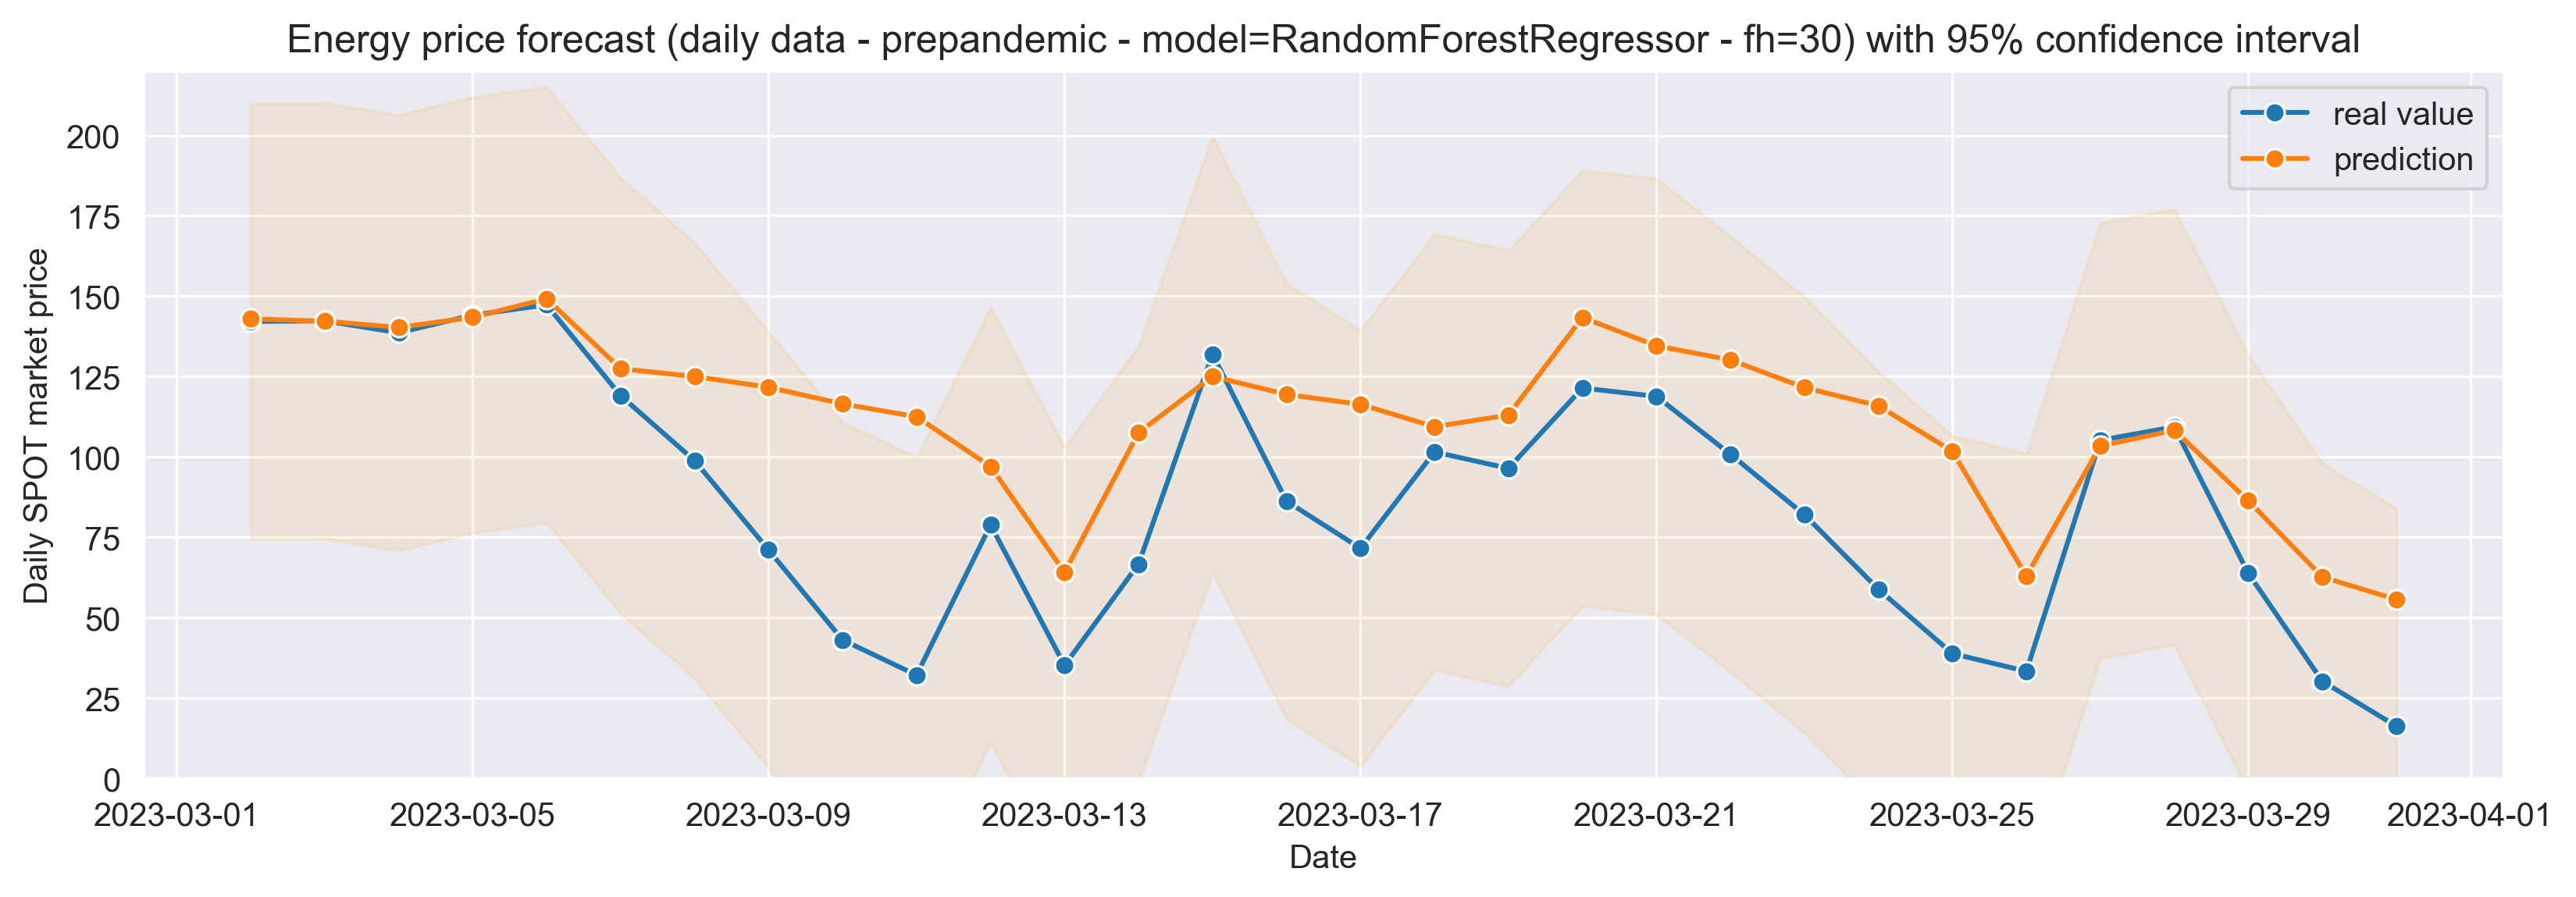

In [56]:
residuals = abs(y_pred-y_date_features_test)
RMSFE = np.sqrt(sum([x**2 for x in residuals]) / len(residuals))
band_size = 1.96*RMSFE

if type(y_date_features_test.index) is pd.core.indexes.period.PeriodIndex:
    y_date_features_test.index = y_date_features_test.index.to_timestamp()
if type(y_pred.index) is pd.core.indexes.period.PeriodIndex:
    y_pred.index = y_pred.index.to_timestamp()

fig, ax = plt.subplots(figsize=(13,4))
sns.lineplot(data=y_date_features_test, palette="deepskyblue", marker="o", ax=ax)
sns.lineplot(data=y_pred, palette="orange", marker="o", ax=ax)
ax.fill_between(y_date_features_test.index, (y_date_features_test-band_size), (y_date_features_test+band_size), color='orange', alpha=.1)
ax.set_title(f"Energy price forecast (daily data - prepandemic - model={best_model_string} - fh={forecasting_horizon}) with 95% confidence interval")
ax.set_xlabel('Date')
ax.set_ylabel('Daily SPOT market price')
ax.set_ylim([0,220])
ax.legend(loc="upper right", labels=["real value", "prediction"])
plt.show()